# Studying parameter development of the full interaction model

In [2]:
import os
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind as ttest
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Tuple
import json

import pymc as pm
print(f"Running on PyMC v{pm.__version__}")
import bambi as bmb
print(f"Running on bmb v{bmb.__version__}")
import arviz as az
az.style.use("arviz-darkgrid") # make e.g. forestplot use a grid

# custom scripts
import dataLoader
from buttler import *

with open("./settings.json") as f:
    settings = json.load(f)

Running on PyMC v5.6.1
Running on bmb v0.12.0


## 0. Load and Pre-process Data

In [3]:
# %%capture --no-display --no-stdout
# data loading and pre-processing
df, SESSION_IDS = dataLoader.loadCausalityData()
df = dataLoader.shiftColumns(df, ["causality_judgement", "time", "angle"], SESSION_IDS)

# add columns that count sequences of 'causa'/'non-causal' responses
df = df.groupby(SESSION_IDS, group_keys=False).apply(countResponses)
# display(df.head(3))

# select and rename needed columns
data = df [["subject_id", "baseline_stimulation", "stimulation", "group", "causality_judgement1", "time", "time1", "angle", "angle1", "c_seq", "nc_seq", "causality_judgement", "RT", "RT_corrected_for_delay"]]
data.columns = ["subj", "base_stim", "stim", "group", "c1", "time", "time1", "angle", "angle1", "c_seq", "nc_seq", "c", "rt", "rt_c"]

DATA_SESSION_IDS = ['subj', 'base_stim', 'stim', 'group']

# name categorical values
data.loc[:, "group"] = data.loc[:, "group"].replace({0: "HC", 1: "SZ"})
# data["group"] = data["group"].replace({0: "HC", 1: "SZ"}) # Has same effect and throws same error as above...
data["c"] = data["c"].replace({0: "non_causal", 1: "causal"})
data["c1"] = data["c1"].replace({0: "non_causal", 1: "causal"})
data.head(3)

Causality data shape: (42966, 10)
Shifted Data shape: (42526, 13)


C:\Users\key\AppData\Local\Temp\ipykernel_7432\380323668.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["c"] = data["c"].replace({0: "non_causal", 1: "causal"})
C:\Users\key\AppData\Local\Temp\ipykernel_7432\380323668.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["c1"] = data["c1"].replace({0: "non_causal", 1: "causal"})


subj  base_stim  stim group          c1  time  time1  angle  angle1  \
id                                                                        
1    2.0        1.0   1.0    HC      causal   0.0    4.0   30.0    22.5   
2    2.0        1.0   1.0    HC      causal  16.0    0.0   22.5    30.0   
3    2.0        1.0   1.0    HC  non_causal   0.0   16.0    0.0    22.5   

    c_seq  nc_seq           c      rt     rt_c  
id                                              
1       1       0      causal  1480.6  1480.60  
2       2       0  non_causal  1615.0  1348.44  
3       0       1      causal  1395.2  1395.20

In [4]:
# drop outlying participants
print(f"percentage of 'causal' responses for subj 16: { data[data['subj'] == 16].replace({'causal': 1, 'non_causal': 0})['c'].mean()}")
print(f"percentage of 'causal' responses for subj 104: { data[data['subj'] == 104].replace({'causal': 1, 'non_causal': 0})['c'].mean()}")

data = data[data["subj"] != 16]
data = data[data["subj"] != 104]

percentage of 'causal' responses for subj 16: 0.9830633284241531
percentage of 'causal' responses for subj 104: 1.0


In [5]:
# cap too long reaction time
# rt_limit = data["rt"].mean() + 4 * data["rt"].std() # = 3972.09 ms
rt_limit = 10000

print(f"Cutting off response time of {data[data['rt'] >= rt_limit].shape[0]} trials.")
print(f"This translates to {round((data[data['rt'] >= rt_limit].shape[0] / data.shape[0]) * 100, 2)} % of all trials.")

rt_idx = data[data["rt"] >= rt_limit].index
data.loc[rt_idx, "rt"] = rt_limit

rt_c_idx = data[data["rt"] >= rt_limit].index
data.loc[rt_c_idx, "rt_c"] = rt_limit

Cutting off response time of 14 trials.
This translates to 0.03 % of all trials.


In [6]:
# standardize data
for col in ["angle", "angle1", "time", "time1"]:
    data[col + "_std"] = standardize(data[col])

# normalize data
data = data.groupby(["subj"], group_keys=False).apply(normalize, ["rt", "rt_c", "angle", "time", "angle1", "time1"])
data.columns

Index(['subj', 'base_stim', 'stim', 'group', 'c1', 'time', 'time1', 'angle',
       'angle1', 'c_seq', 'nc_seq', 'c', 'rt', 'rt_c', 'angle_std',
       'angle1_std', 'time_std', 'time1_std', 'rt_norm', 'rt_c_norm',
       'angle_norm', 'time_norm', 'angle1_norm', 'time1_norm'],
      dtype='object')

In [7]:
# nest data
nested_model_data, new_cols_c1 = nestPredictors(data, "c1", "group", drop_inner=False)
nested_model_data, new_cols_time = nestPredictors(nested_model_data, "time", "group", drop_inner=False)
nested_model_data, new_cols_angle = nestPredictors(nested_model_data, "angle", "group", drop_inner=False)

nested_model_data, new_cols_time = nestPredictors(nested_model_data, "time_std", "group", drop_inner=False)
nested_model_data, new_cols_angle = nestPredictors(nested_model_data, "angle_std", "group", drop_inner=False)

nested_model_data, new_cols_time = nestPredictors(nested_model_data, "time_norm", "group", drop_inner=False)
nested_model_data, new_cols_angle = nestPredictors(nested_model_data, "angle_norm", "group", drop_inner=False)

def split_tDCS(group:pd.DataFrame) -> pd.DataFrame:
    stim = group["stim"].iloc[0]
    group["tDCS_" + str(int(stim))] = group["base_stim"] == 2
    return group

nested_model_data = nested_model_data.groupby(["stim"], group_keys=False).apply(split_tDCS)

def apply_tDCS_contrasts(data:pd.DataFrame) -> pd.DataFrame:
    data2 = data.copy()
    constrasts = {
        True: 1,
        False: -1,
        np.NaN: 0
    }
    columns = ["tDCS_" + str(i+1) for i in range(7)]

    data2[columns] = data2[columns].replace(constrasts)
    return data2

nested_model_data = applyCustomConstrasts(nested_model_data, columns=["c1", "group", "c1_HC", "c1_SZ"], kind="Sum")
nested_model_data = apply_tDCS_contrasts(nested_model_data)

# custom nesting for last trial properties
nested_model_data["time1_norm_HC"] =(nested_model_data["group"] == -1) * nested_model_data["time1_norm"]
nested_model_data["time1_norm_SZ"] =(nested_model_data["group"] == 1) * nested_model_data["time1_norm"]
nested_model_data["angle1_norm_HC"] =(nested_model_data["group"] == -1) * nested_model_data["angle1_norm"]
nested_model_data["angle1_norm_SZ"] =(nested_model_data["group"] == 1) * nested_model_data["angle1_norm"]

display(nested_model_data.head(2))
print(f"We now have available the following predictors/ columns:\n{nested_model_data.columns}")

subj  base_stim  stim  group  c1  time  time1  angle  angle1  c_seq  ...  \
id                                                                       ...   
1    2.0        1.0   1.0     -1   1   0.0    4.0   30.0    22.5      1  ...   
2    2.0        1.0   1.0     -1   1  16.0    0.0   22.5    30.0      2  ...   

    tDCS_2 tDCS_3  tDCS_4  tDCS_5  tDCS_6  tDCS_7  time1_norm_HC  \
id                                                                 
1      0.0    0.0     0.0     0.0     0.0     0.0      -0.547538   
2      0.0    0.0     0.0     0.0     0.0     0.0      -1.312343   

    time1_norm_SZ  angle1_norm_HC  angle1_norm_SZ  
id                                                 
1            -0.0       -0.159477            -0.0  
2            -0.0        0.224911             0.0  

[2 rows x 49 columns]

We now have available the following predictors/ columns:
Index(['subj', 'base_stim', 'stim', 'group', 'c1', 'time', 'time1', 'angle',
       'angle1', 'c_seq', 'nc_seq', 'c', 'rt', 'rt_c', 'angle_std',
       'angle1_std', 'time_std', 'time1_std', 'rt_norm', 'rt_c_norm',
       'angle_norm', 'time_norm', 'angle1_norm', 'time1_norm', 'c1_HC',
       'c1_SZ', 'time_HC', 'time_SZ', 'angle_HC', 'angle_SZ', 'time_std_HC',
       'time_std_SZ', 'angle_std_HC', 'angle_std_SZ', 'time_norm_HC',
       'time_norm_SZ', 'angle_norm_HC', 'angle_norm_SZ', 'tDCS_1', 'tDCS_2',
       'tDCS_3', 'tDCS_4', 'tDCS_5', 'tDCS_6', 'tDCS_7', 'time1_norm_HC',
       'time1_norm_SZ', 'angle1_norm_HC', 'angle1_norm_SZ'],
      dtype='object')


In [8]:
# Rename time to delay

new_cols = []
for n in nested_model_data.columns:
    n = n.replace("time", "delay")
    new_cols.append(n)

nested_model_data.columns = new_cols
nested_model_data.columns

Index(['subj', 'base_stim', 'stim', 'group', 'c1', 'delay', 'delay1', 'angle',
       'angle1', 'c_seq', 'nc_seq', 'c', 'rt', 'rt_c', 'angle_std',
       'angle1_std', 'delay_std', 'delay1_std', 'rt_norm', 'rt_c_norm',
       'angle_norm', 'delay_norm', 'angle1_norm', 'delay1_norm', 'c1_HC',
       'c1_SZ', 'delay_HC', 'delay_SZ', 'angle_HC', 'angle_SZ', 'delay_std_HC',
       'delay_std_SZ', 'angle_std_HC', 'angle_std_SZ', 'delay_norm_HC',
       'delay_norm_SZ', 'angle_norm_HC', 'angle_norm_SZ', 'tDCS_1', 'tDCS_2',
       'tDCS_3', 'tDCS_4', 'tDCS_5', 'tDCS_6', 'tDCS_7', 'delay1_norm_HC',
       'delay1_norm_SZ', 'angle1_norm_HC', 'angle1_norm_SZ'],
      dtype='object')

## 1. Testing for order effects - Model fits/ loads

It seems that with time SZs take the last response into account differently than HCs. 
Let us compare the progression of the c1 parameter for HCs and SZs throughout one session, by splitting the data of one session into 4 parts:
* 2 parts before stimulation
* 2 parts after stimulation

To see how the parameter develops with time.

In [9]:
TRACE_PATH = os.path.join(settings["trace_path"], "causality", "parameter_development")
os.makedirs(TRACE_PATH, exist_ok=True)

In [10]:
# splitting the data in 4 batches
def split_tdcs_session1(group):
    split_idx = int(group.shape[0] / 2)
    first = group.iloc[:split_idx, :]
    return first
def split_tdcs_session2(group):
    split_idx = int(group.shape[0] / 2)
    second = group.iloc[split_idx:, :]
    return second

mydata_pre = nested_model_data[nested_model_data["base_stim"] == 1]
mydata_pre1 = mydata_pre.groupby(["subj", "base_stim", "stim", "group"], group_keys=False).apply(split_tdcs_session1)
mydata_pre2 = mydata_pre.groupby(["subj", "base_stim", "stim", "group"], group_keys=False).apply(split_tdcs_session2)

mydata_post = nested_model_data[nested_model_data["base_stim"] == 2]
mydata_post1 = mydata_post.groupby(["subj", "base_stim", "stim", "group"], group_keys=False).apply(split_tdcs_session1)
mydata_post2 = mydata_post.groupby(["subj", "base_stim", "stim", "group"], group_keys=False).apply(split_tdcs_session2)

### 1.1. Estimating the full interaction model over the course of a session

In [11]:
display_summaries = False
# part pre 1
trace_file = os.path.join(TRACE_PATH, "properties_c1_interactions_full_pre_1.nc")
model_properties_c1_interactions_full_pre_1 = bmb.Model("c ~ group * delay_norm * angle_norm * c1 * angle1_norm * delay1_norm + (1|subj)", mydata_pre1, family="bernoulli")
trace_properties_c1_interactions_full_pre_1 = loadOrSample(model_properties_c1_interactions_full_pre_1, trace_file)

# part pre 2
trace_file = os.path.join(TRACE_PATH, "properties_c1_interactions_full_pre_2.nc")
model_properties_c1_interactions_full_pre_2 = bmb.Model("c ~ group * delay_norm * angle_norm * c1 * angle1_norm * delay1_norm + (1|subj)", mydata_pre2, family="bernoulli")
trace_properties_c1_interactions_full_pre_2 = loadOrSample(model_properties_c1_interactions_full_pre_2, trace_file)

# part post 1
trace_file = os.path.join(TRACE_PATH, "properties_c1_interactions_full_post_1.nc")
model_properties_c1_interactions_full_post_1 = bmb.Model("c ~ group * delay_norm * angle_norm * c1 * angle1_norm * delay1_norm + (1|subj)", mydata_post1, family="bernoulli")
trace_properties_c1_interactions_full_post_1 = loadOrSample(model_properties_c1_interactions_full_post_1, trace_file)

# part post 2
trace_file = os.path.join(TRACE_PATH, "properties_c1_interactions_full_post_2.nc")
model_properties_c1_interactions_full_post_2 = bmb.Model("c ~ group * delay_norm * angle_norm * c1 * angle1_norm * delay1_norm + (1|subj)", mydata_post2, family="bernoulli")
trace_properties_c1_interactions_full_post_2 = loadOrSample(model_properties_c1_interactions_full_post_2, trace_file)

Loading trace from file.
Loading trace from file.
Loading trace from file.
Loading trace from file.


In [12]:
traces = {
    "1_pre1": trace_properties_c1_interactions_full_pre_1,
    "2_pre2": trace_properties_c1_interactions_full_pre_2,
    "3_post1": trace_properties_c1_interactions_full_post_1,
    "4_post2": trace_properties_c1_interactions_full_post_2
}

### 1.2. Visualize Parameter development

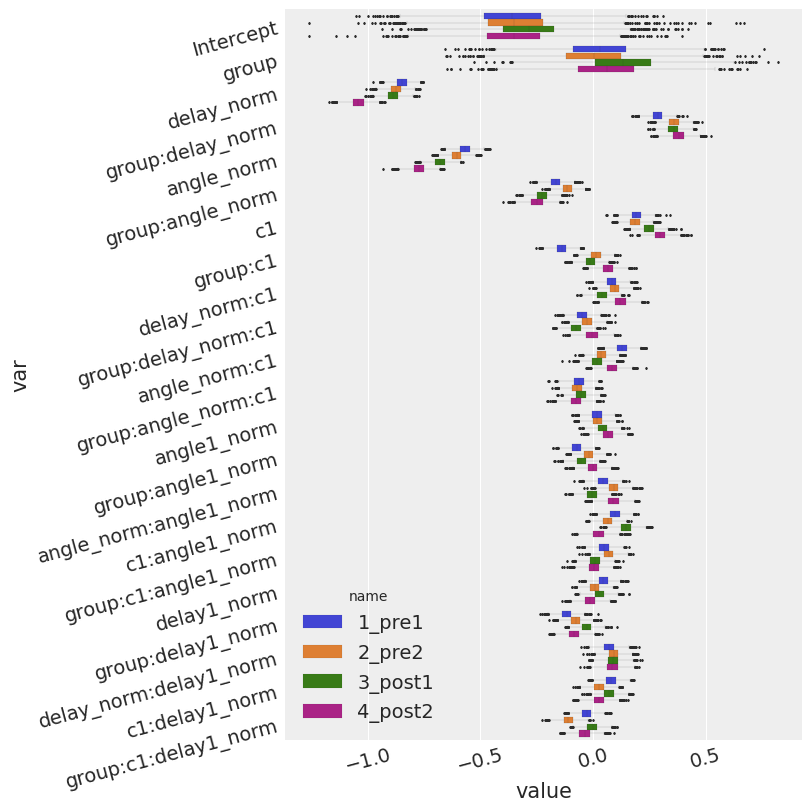

In [13]:
summaries = pd.DataFrame()
for name in traces.keys():
    summary = traces[name].posterior.to_dataframe().reset_index(drop=True).drop(columns=["1|subj_sigma", "1|subj"]).drop_duplicates()
    summary["name"] = name
    summaries = pd.concat([summaries, summary])

# select parameters to be compared
params = [
    "Intercept",
    'group',
    'delay_norm','group:delay_norm',
    'angle_norm','group:angle_norm',
    'c1','group:c1','delay_norm:c1','group:delay_norm:c1','angle_norm:c1','group:angle_norm:c1',
    'angle1_norm', 'group:angle1_norm', 'angle_norm:angle1_norm', 'c1:angle1_norm', 'group:c1:angle1_norm',
    'delay1_norm', 'group:delay1_norm', 'delay_norm:delay1_norm', 'c1:delay1_norm', 'group:c1:delay1_norm',
    "name"
    ]

summaries = summaries[params]

def stack(group):
    name = group["name"].iloc[0]
    group = group.drop(columns=["name"])
    group = group.stack().reset_index()
    group.columns = ["level", "var", "value"]
    group["name"] = name
    return group
sum_long = summaries.groupby("name", group_keys=False).apply(stack)
# sum_long = sum_long.sort_values(by="name", ascending=False)

fig, axs = plt.subplots(1,1, figsize=(8,8))
sns.boxplot(sum_long, x="value", y="var", orient="h", hue="name", 
                # width=0.5,
                linewidth=0.1, fliersize=1)

plt.tick_params(labelrotation=15)

Delay and angle influence over time for HCs and SSDs

#### Reportable figures

Plotting selected parameters

In [14]:
traces = {
    "1_pre1": trace_properties_c1_interactions_full_pre_1,
    "2_pre2": trace_properties_c1_interactions_full_pre_2,
    "3_post1": trace_properties_c1_interactions_full_post_1,
    "4_post2": trace_properties_c1_interactions_full_post_2
}
summaries = pd.DataFrame()
for name in traces.keys():
    summary = traces[name].posterior.to_dataframe().reset_index(drop=True).drop(columns=["1|subj_sigma", "1|subj"])#.drop_duplicates()
    summary["name"] = name
    summaries = pd.concat([summaries, summary])

summaries

Intercept     group  delay_norm  group:delay_norm  angle_norm  \
0       -0.076870 -0.359367   -0.879257           0.31072   -0.575088   
1       -0.076870 -0.359367   -0.879257           0.31072   -0.575088   
2       -0.076870 -0.359367   -0.879257           0.31072   -0.575088   
3       -0.076870 -0.359367   -0.879257           0.31072   -0.575088   
4       -0.076870 -0.359367   -0.879257           0.31072   -0.575088   
...           ...       ...         ...               ...         ...   
151995  -0.159851 -0.114071   -1.046947           0.36876   -0.772822   
151996  -0.159851 -0.114071   -1.046947           0.36876   -0.772822   
151997  -0.159851 -0.114071   -1.046947           0.36876   -0.772822   
151998  -0.159851 -0.114071   -1.046947           0.36876   -0.772822   
151999  -0.159851 -0.114071   -1.046947           0.36876   -0.772822   

        group:angle_norm  delay_norm:angle_norm  group:delay_norm:angle_norm  \
0              -0.124172              -0.059201                    -0.025765   
1              -0.124172              -0.059201                    -0.025765   
2              -0.124172              -0.059201                    -0.025765   
3              -0.124172              -0.059201                    -0.025765   
4              -0.124172              -0.059201                    -0.025765   
...                  ...                    ...                          ...   
151995         -0.275121              -0.023642                    -0.024373   
151996         -0.275121              -0.023642                    -0.024373   
151997         -0.275121              -0.023642                    -0.024373   
151998         -0.275121              -0.023642                    -0.024373   
151999         -0.275121              -0.023642                    -0.024373   

              c1  group:c1  ...  \
0       0.218033 -0.130535  ...   
1       0.218033 -0.130535  ...   
2       0.218033 -0.130535  ...   
3       0.218033 -0.130535  ...   
4       0.218033 -0.130535  ...   
...          ...       ...  ...   
151995  0.278836  0.070459  ...   
151996  0.278836  0.070459  ...   
151997  0.278836  0.070459  ...   
151998  0.278836  0.070459  ...   
151999  0.278836  0.070459  ...   

        group:delay_norm:angle_norm:angle1_norm:delay1_norm  \
0                                               -0.028971     
1                                               -0.028971     
2                                               -0.028971     
3                                               -0.028971     
4                                               -0.028971     
...                                                   ...     
151995                                          -0.052461     
151996                                          -0.052461     
151997                                          -0.052461     
151998                                          -0.052461     
151999                                          -0.052461     

        c1:angle1_norm:delay1_norm  group:c1:angle1_norm:delay1_norm  \
0                         0.073283                          0.029001   
1                         0.073283                          0.029001   
2                         0.073283                          0.029001   
3                         0.073283                          0.029001   
4                         0.073283                          0.029001   
...                            ...                               ...   
151995                   -0.017668                         -0.006471   
151996                   -0.017668                         -0.006471   
151997                   -0.017668                         -0.006471   
151998                   -0.017668                         -0.006471   
151999                   -0.017668                         -0.006471   

        delay_norm:c1:angle1_norm:delay1_norm  \
0                                   -0.000251   
1                            

Extended boxplot for the Supplementary Material

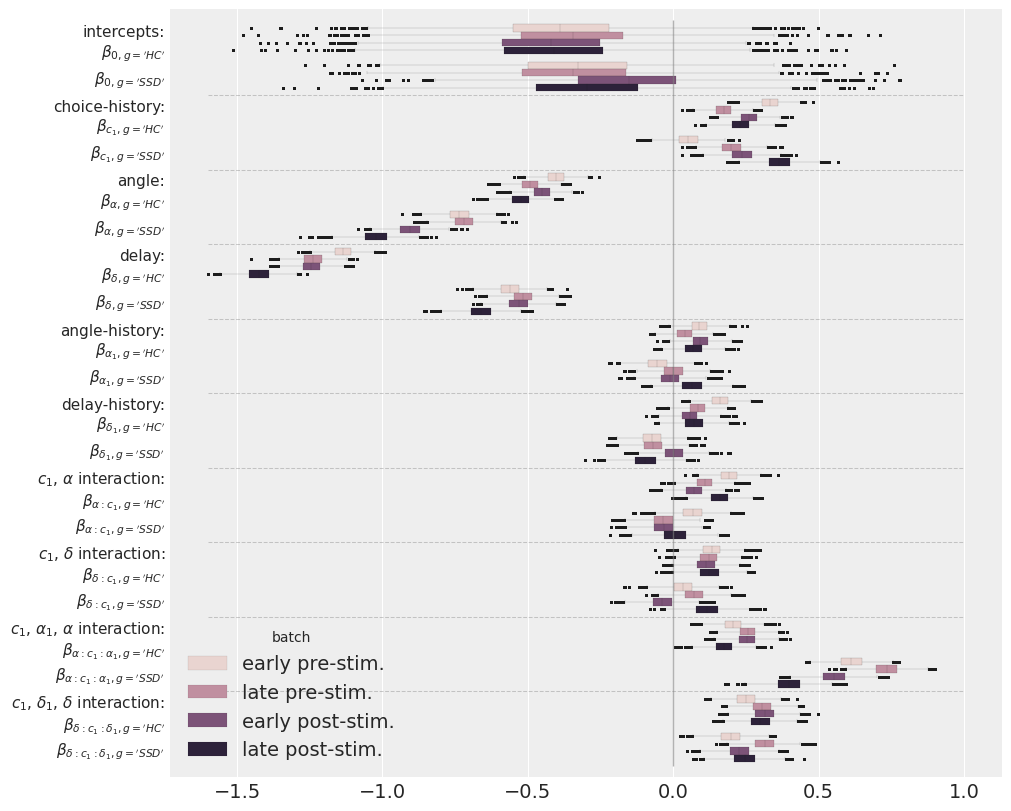

In [16]:
traces = {
    "1_pre1": trace_properties_c1_interactions_full_pre_1,
    "2_pre2": trace_properties_c1_interactions_full_pre_2,
    "3_post1": trace_properties_c1_interactions_full_post_1,
    "4_post2": trace_properties_c1_interactions_full_post_2
}
summaries = pd.DataFrame()
for name in traces.keys():
    summary = traces[name].posterior.to_dataframe().reset_index(drop=True).drop(columns=["1|subj_sigma", "1|subj"])#.drop_duplicates()
    summary["name"] = name
    summaries = pd.concat([summaries, summary])

# calculate group specific parameters using means and interaction effects
summaries["inter_HC"] = summaries["Intercept"] - summaries["group"]
summaries["inter_SSD"] = summaries["Intercept"] + summaries["group"]

summaries["c1_HC"] = summaries["c1"] - summaries["group:c1"]
summaries["c1_SZ"] = summaries["c1"] + summaries["group:c1"]

summaries["delay_HC"] = summaries["delay_norm"] - summaries["group:delay_norm"]
summaries["delay_SZ"] = summaries["delay_norm"] + summaries["group:delay_norm"]
summaries["angle_HC"] = summaries["angle_norm"] - summaries["group:angle_norm"]
summaries["angle_SZ"] = summaries["angle_norm"] + summaries["group:angle_norm"]
summaries["delay1_HC"] = summaries["delay1_norm"] - summaries["group:delay1_norm"]
summaries["delay1_SZ"] = summaries["delay1_norm"] + summaries["group:delay1_norm"]
summaries["angle1_HC"] = summaries["angle1_norm"] - summaries["group:angle1_norm"]
summaries["angle1_SZ"] = summaries["angle1_norm"] + summaries["group:angle1_norm"]

summaries["a:c1_HC"] = summaries["angle_norm:c1"] - summaries["group:angle_norm:c1"]
summaries["a:c1_SZ"] = summaries["angle_norm:c1"] + summaries["group:angle_norm:c1"]
summaries["d:c1_HC"] = summaries["delay_norm:c1"] - summaries["group:delay_norm:c1"]
summaries["d:c1_SZ"] = summaries["delay_norm:c1"] + summaries["group:delay_norm:c1"]


summaries["a:c1:a1_HC"] = summaries["angle_norm:c1:angle1_norm"] - summaries["group:angle_norm:c1:angle1_norm"]
summaries["a:c1:a1_SSD"] = summaries["angle_norm:c1:angle1_norm"] + summaries["group:angle_norm:c1:angle1_norm"]

summaries["d:c1:d1_HC"] = summaries["delay_norm:c1:delay1_norm"] - summaries["group:delay_norm:c1:delay1_norm"]
summaries["d:c1:d1_SSD"] = summaries["delay_norm:c1:delay1_norm"] + summaries["group:delay_norm:c1:delay1_norm"]

# select columns for plotting
new_cols = ["inter_HC", "inter_SSD",
    
            "c1_HC", "c1_SZ",
            "angle_HC", "angle_SZ", "delay_HC", "delay_SZ",

            # trial-history
            "angle1_HC", "angle1_SZ", "delay1_HC", "delay1_SZ",

            # choice-history property interactions
            "a:c1_HC", "a:c1_SZ",
            "d:c1_HC", "d:c1_SZ",

            # 3 way interactions
            "a:c1:a1_HC", "a:c1:a1_SSD",
            "d:c1:d1_HC", "d:c1:d1_SSD",

            "name"]
summaries = summaries[new_cols]

# rename columns to fit with paper notation
# summaries.columns = ["choice-history, HC\n$\\beta_{c_1, g='HC'}$", "choice-history, SSD\n$\\beta_{c_1, g='SSD'}$",
#                     "angle, HC\n$\\beta_{\\alpha, g='HC'}$", "angle, SSD\n$\\beta_{\\alpha, g='SSD'}$",
#                     "delay, HC\n$\\beta_{\\delta, g='HC'}$", "delay, SSD\n$\\beta_{\\delta, g='SSD'}$",
#                     "angle-history, HC\n$\\beta_{\\alpha_1, g='HC'}$", "angle-history, SSD\n$\\beta_{\\alpha_1, g='SSD'}$",
#                     "delay-history, HC\n$\\beta_{\\delta_1, g='HC'}$", "delay-history, SSD\n$\\beta_{\\delta_1, g='SSD'}$",

#                     "c, $\\alpha_1$, $\\alpha$ interaction, HC\n$\\beta_{\\alpha:c_1:\\alpha_1, g='HC'}$", 
#                     "c, $\\alpha_1$, $\\alpha$ interaction, SSD\n$\\beta_{\\alpha:c_1:\\alpha_1, g='SSD'}$",
#                     # "d:c1:d1_HC", "d:c1:d1_SSD",
#                     "name"]
summaries.columns = ["intercepts:\n$\\beta_{0, g='HC'}$", "$\\beta_{0, g='SSD'}$",

                    "choice-history:\n$\\beta_{c_1, g='HC'}$", "$\\beta_{c_1, g='SSD'}$",
                    "angle:\n$\\beta_{\\alpha, g='HC'}$", "$\\beta_{\\alpha, g='SSD'}$",
                    "delay:\n$\\beta_{\\delta, g='HC'}$", "$\\beta_{\\delta, g='SSD'}$",

                    # trial-history
                    "angle-history:\n$\\beta_{\\alpha_1, g='HC'}$", "$\\beta_{\\alpha_1, g='SSD'}$",
                    "delay-history:\n$\\beta_{\\delta_1, g='HC'}$", "$\\beta_{\\delta_1, g='SSD'}$",

                    # choice-history property interactions
                    "$c_1$, $\\alpha$ interaction:\n$\\beta_{\\alpha:c_1, g='HC'}$", "$\\beta_{\\alpha:c_1, g='SSD'}$",
                    "$c_1$, $\\delta$ interaction:\n$\\beta_{\\delta:c_1, g='HC'}$", "$\\beta_{\\delta:c_1, g='SSD'}$",

                    # 3 way interactions
                    "$c_1$, $\\alpha_1$, $\\alpha$ interaction:\n$\\beta_{\\alpha:c_1:\\alpha_1, g='HC'}$", 
                    "$\\beta_{\\alpha:c_1:\\alpha_1, g='SSD'}$",

                    "$c_1$, $\\delta_1$, $\\delta$ interaction:\n$\\beta_{\\delta:c_1:\\delta_1, g='HC'}$", 
                    "$\\beta_{\\delta:c_1:\\delta_1, g='SSD'}$",

                    "name"]

# reshape/ stack data for plotting
def stack(group):
    name = group["name"].iloc[0]
    group = group.drop(columns=["name"])
    group = group.stack().reset_index()
    group.columns = ["level", "var", "value"]
    group["name"] = name
    return group
sum_long = summaries.groupby("name", group_keys=False).apply(stack)


# define colors
colors = ["red", "blue", "green", "yellow"]
colors = sns.cubehelix_palette(4)

# create figure
fig, axs = plt.subplots(1,1, figsize=(10,8)) # (8,6)

# prepare background
# axs.fill_between([-1.65, 0.6], 1.5, 5.5, color="lightgrey", alpha=0.2)

# plot data
g = sns.boxplot(sum_long, x="value", y="var", orient="h", hue="name", 
                # width=0.5, 
                palette=colors, 
                linewidth=0.1, fliersize=1)

# styling
## set labels in legend
labels = ["early pre-stim.", "late pre-stim.", "early post-stim.", "late post-stim."]
plt.legend(title="batch")
for text_field, label in zip(g.legend_.texts, labels):
    text_field.set_text(label)

plt.ylabel("")
plt.xlabel("")

## add lines
axs.vlines([0], [-0.5], [len(summaries.columns) - 1.5], linestyles="-", alpha=0.6, linewidth=1, color="grey") # 9.5

for i in range(1, 18, 2):
    axs.hlines([.5 + i], [-1.6], [1.0], linestyles="--", linewidth=0.75, alpha=0.4, color="grey") # right limit used to be 0.6
# axs.hlines([1.5], [-1.6], [1.0], linestyles="--", linewidth=0.75, alpha=0.4, color="grey") # right limit used to be 0.6
# axs.hlines([3.5], [-1.6], [1.0], linestyles="--", linewidth=0.75, alpha=0.4, color="grey") # right limit used to be 0.6
# axs.hlines([5.5], [-1.6], [1.0], linestyles="--", linewidth=0.75, alpha=0.4, color="grey") # right limit used to be 0.6
# axs.hlines([7.5], [-1.6], [1.0], linestyles="--", linewidth=0.75, alpha=0.4, color="grey") # right limit used to be 0.6
# axs.hlines([9.5], [-1.6], [1.0], linestyles="--", linewidth=0.75, alpha=0.4, color="grey") # right limit used to be 0.6

## set axes limitations
# axs.set_xlim(-1.65, 0.65)
# axs.set_ylim(9.6, -0.6)

# set y tick font size
plt.yticks(fontsize=11)#, rotation=15)

plt.tight_layout()
# plt.savefig("figures/order_effects_extended.pdf")

### 1.3. Table of Parameter development

In [17]:
for key in traces:
    display(az.summary(traces[key])[["mean", "sd"]].head())

mean     sd
Intercept        -0.359  0.186
group             0.029  0.176
delay_norm       -0.849  0.031
group:delay_norm  0.287  0.031
angle_norm       -0.570  0.032

mean     sd
Intercept        -0.344  0.191
group             0.004  0.190
delay_norm       -0.878  0.033
group:delay_norm  0.360  0.032
angle_norm       -0.606  0.032

mean     sd
Intercept        -0.287  0.179
group             0.134  0.184
delay_norm       -0.888  0.033
group:delay_norm  0.357  0.032
angle_norm       -0.679  0.032

mean     sd
Intercept        -0.351  0.181
group             0.055  0.185
delay_norm       -1.043  0.036
group:delay_norm  0.381  0.036
angle_norm       -0.773  0.035

The following cells are for creating and styling a latex table from the reported parameter distributions

In [18]:
pd.concat( [az.summary(traces[key])[["mean", "sd"]] for key in traces] , axis=1).to_latex()

'\\begin{tabular}{lrrrrrrrr}\n\\toprule\n & mean & sd & mean & sd & mean & sd & mean & sd \\\\\n\\midrule\nIntercept & -0.359000 & 0.186000 & -0.344000 & 0.191000 & -0.287000 & 0.179000 & -0.351000 & 0.181000 \\\\\ngroup & 0.029000 & 0.176000 & 0.004000 & 0.190000 & 0.134000 & 0.184000 & 0.055000 & 0.185000 \\\\\ndelay_norm & -0.849000 & 0.031000 & -0.878000 & 0.033000 & -0.888000 & 0.033000 & -1.043000 & 0.036000 \\\\\ngroup:delay_norm & 0.287000 & 0.031000 & 0.360000 & 0.032000 & 0.357000 & 0.032000 & 0.381000 & 0.036000 \\\\\nangle_norm & -0.570000 & 0.032000 & -0.606000 & 0.032000 & -0.679000 & 0.032000 & -0.773000 & 0.035000 \\\\\ngroup:angle_norm & -0.166000 & 0.032000 & -0.114000 & 0.031000 & -0.226000 & 0.032000 & -0.249000 & 0.036000 \\\\\ndelay_norm:angle_norm & -0.016000 & 0.032000 & -0.016000 & 0.033000 & 0.008000 & 0.034000 & -0.019000 & 0.037000 \\\\\ngroup:delay_norm:angle_norm & -0.012000 & 0.033000 & 0.014000 & 0.032000 & -0.093000 & 0.034000 & -0.015000 & 0.038000 \\\

\begin{longtable}{l | rr | rr | rr | rr }
 & \multicolumn{2}{c|}{Pre-stim early} & \multicolumn{2}{c|}{Pre-stim late} & \multicolumn{2}{c|}{Post-stim early} & \multicolumn{2}{c|}{Post-stim late} \\
 & Mean & SD & Mean & SD & Mean & SD & Mean & SD \\
\hline
\hline

0 (intercept) & \textbf{-0.359} & 0.186 & \textbf{-0.344} & 0.191 & \textbf{-0.287} & 0.179 & \textbf{-0.351} & 0.181 \\
$g$ & \textbf{0.029} & 0.176 & \textbf{0.004} & 0.190 & \textbf{0.134} & 0.184 & \textbf{0.055} & 0.185 \\
$\delta$ & \textbf{-0.849} & 0.031 & \textbf{-0.878} & 0.033 & \textbf{-0.888} & 0.033 & \textbf{-1.043} & 0.036 \\
$g:\delta$ & \textbf{0.287} & 0.031 & \textbf{0.360} & 0.032 & \textbf{0.357} & 0.032 & \textbf{0.381} & 0.036 \\
$\alpha$ & \textbf{-0.570} & 0.032 & \textbf{-0.606} & 0.032 & \textbf{-0.679} & 0.032 & \textbf{-0.773} & 0.035 \\
$g:\alpha$ & \textbf{-0.166} & 0.032 & \textbf{-0.114} & 0.031 & \textbf{-0.226} & 0.032 & \textbf{-0.249} & 0.036 \\
$\delta:\alpha$ & \textbf{-0.016} & 0.032 & \textbf{-0.016} & 0.033 & \textbf{0.008} & 0.034 & \textbf{-0.019} & 0.037 \\
$g:\delta:\alpha$ & \textbf{-0.012} & 0.033 & \textbf{0.014} & 0.032 & \textbf{-0.093} & 0.034 & \textbf{-0.015} & 0.038 \\
$c_1$ & \textbf{0.193} & 0.031 & \textbf{0.187} & 0.030 & \textbf{0.248} & 0.032 & \textbf{0.299} & 0.035 \\
$g:c_1$ & \textbf{-0.140} & 0.031 & \textbf{0.014} & 0.031 & \textbf{-0.012} & 0.032 & \textbf{0.067} & 0.034 \\
$\delta:c_1$ & \textbf{0.083} & 0.031 & \textbf{0.097} & 0.032 & \textbf{0.038} & 0.033 & \textbf{0.120} & 0.037 \\
$g:\delta:c_1$ & \textbf{-0.049} & 0.032 & \textbf{-0.025} & 0.032 & \textbf{-0.075} & 0.033 & \textbf{-0.004} & 0.036 \\
$\alpha:c_1$ & \textbf{0.130} & 0.031 & \textbf{0.037} & 0.031 & \textbf{0.019} & 0.033 & \textbf{0.084} & 0.035 \\
$g:\alpha:c_1$ & \textbf{-0.063} & 0.031 & \textbf{-0.071} & 0.031 & \textbf{-0.052} & 0.032 & \textbf{-0.077} & 0.035 \\
$\delta:\alpha:c_1$ & \textbf{0.046} & 0.033 & \textbf{0.081} & 0.033 & \textbf{0.067} & 0.034 & \textbf{0.227} & 0.038 \\
$g:\delta:\alpha:c_1$ & \textbf{-0.025} & 0.032 & \textbf{-0.032} & 0.033 & \textbf{-0.020} & 0.035 & \textbf{-0.046} & 0.037 \\
$\alpha_1$ & \textbf{0.018} & 0.031 & \textbf{0.020} & 0.031 & \textbf{0.042} & 0.031 & \textbf{0.067} & 0.033 \\
$g:\alpha_1$ & \textbf{-0.072} & 0.031 & \textbf{-0.019} & 0.030 & \textbf{-0.052} & 0.031 & \textbf{-0.003} & 0.033 \\
$\delta:\alpha_1$ & \textbf{-0.009} & 0.031 & \textbf{0.041} & 0.033 & \textbf{-0.046} & 0.033 & \textbf{0.019} & 0.036 \\
$g:\delta:\alpha_1$ & \textbf{-0.032} & 0.032 & \textbf{-0.044} & 0.033 & \textbf{0.002} & 0.033 & \textbf{0.052} & 0.035 \\
$\alpha:\alpha_1$ & \textbf{0.044} & 0.033 & \textbf{0.092} & 0.032 & \textbf{-0.004} & 0.033 & \textbf{0.090} & 0.036 \\
$g:\alpha:\alpha_1$ & \textbf{0.076} & 0.033 & \textbf{-0.001} & 0.032 & \textbf{0.011} & 0.034 & \textbf{0.055} & 0.036 \\
$\delta:\alpha:\alpha_1$ & \textbf{-0.062} & 0.034 & \textbf{0.029} & 0.034 & \textbf{-0.070} & 0.036 & \textbf{0.030} & 0.038 \\
$g:\delta:\alpha:\alpha_1$ & \textbf{-0.080} & 0.034 & \textbf{0.014} & 0.035 & \textbf{-0.006} & 0.036 & \textbf{0.056} & 0.037 \\
$c_1:\alpha_1$ & \textbf{0.096} & 0.032 & \textbf{0.065} & 0.031 & \textbf{0.147} & 0.033 & \textbf{0.025} & 0.035 \\
$g:c_1:\alpha_1$ & \textbf{0.049} & 0.032 & \textbf{0.069} & 0.032 & \textbf{0.010} & 0.032 & \textbf{0.004} & 0.034 \\
$\delta:c_1:\alpha_1$ & \textbf{-0.074} & 0.032 & \textbf{-0.002} & 0.033 & \textbf{-0.082} & 0.033 & \textbf{-0.079} & 0.037 \\
$g:\delta:c_1:\alpha_1$ & \textbf{0.089} & 0.033 & \textbf{0.019} & 0.032 & \textbf{0.030} & 0.034 & \textbf{-0.007} & 0.036 \\
$\alpha:c_1:\alpha_1$ & \textbf{0.409} & 0.033 & \textbf{0.495} & 0.033 & \textbf{0.403} & 0.034 & \textbf{0.287} & 0.034 \\
$g:\alpha:c_1:\alpha_1$ & \textbf{0.204} & 0.032 & \textbf{0.239} & 0.033 & \textbf{0.150} & 0.034 & \textbf{0.111} & 0.036 \\
$\delta:\alpha:c_1:\alpha_1$ & \textbf{-0.047} & 0.034 & \textbf{0.067} & 0.035 & \textbf{0.018} & 0.036 & \textbf{0.011} & 0.038 \\
$g:\delta:\alpha:c_1:\alpha_1$ & \textbf{0.004} & 0.034 & \textbf{0.024} & 0.034 & \textbf{-0.008} & 0.036 & \textbf{-0.029} & 0.037 \\
$\delta_1$ & \textbf{0.045} & 0.030 & \textbf{0.008} & 0.031 & \textbf{0.029} & 0.031 & \textbf{-0.012} & 0.034 \\
$g:\delta_1$ & \textbf{-0.117} & 0.030 & \textbf{-0.077} & 0.030 & \textbf{-0.028} & 0.031 & \textbf{-0.083} & 0.034 \\
$\delta:\delta_1$ & \textbf{0.072} & 0.034 & \textbf{0.092} & 0.032 & \textbf{0.090} & 0.033 & \textbf{0.086} & 0.036 \\
$g:\delta:\delta_1$ & \textbf{-0.040} & 0.032 & \textbf{0.024} & 0.032 & \textbf{-0.071} & 0.034 & \textbf{-0.044} & 0.036 \\
$\alpha:\delta_1$ & \textbf{0.003} & 0.031 & \textbf{0.015} & 0.032 & \textbf{-0.035} & 0.032 & \textbf{0.007} & 0.037 \\
$g:\alpha:\delta_1$ & \textbf{-0.025} & 0.032 & \textbf{-0.031} & 0.032 & \textbf{-0.022} & 0.033 & \textbf{-0.013} & 0.036 \\
$\delta:\alpha:\delta_1$ & \textbf{-0.065} & 0.033 & \textbf{0.022} & 0.033 & \textbf{-0.025} & 0.035 & \textbf{0.097} & 0.038 \\
$g:\delta:\alpha:\delta_1$ & \textbf{-0.040} & 0.034 & \textbf{-0.012} & 0.032 & \textbf{-0.033} & 0.036 & \textbf{-0.062} & 0.038 \\
$c_1:\delta_1$ & \textbf{0.081} & 0.031 & \textbf{0.027} & 0.032 & \textbf{0.072} & 0.032 & \textbf{0.026} & 0.034 \\
$g:c_1:\delta_1$ & \textbf{-0.028} & 0.030 & \textbf{-0.109} & 0.031 & \textbf{-0.003} & 0.032 & \textbf{-0.038} & 0.034 \\
$\delta:c_1:\delta_1$ & \textbf{0.224} & 0.033 & \textbf{0.310} & 0.033 & \textbf{0.271} & 0.034 & \textbf{0.272} & 0.036 \\
$g:\delta:c_1:\delta_1$ & \textbf{-0.027} & 0.032 & \textbf{0.004} & 0.032 & \textbf{-0.043} & 0.034 & \textbf{-0.026} & 0.035 \\
$\alpha:c_1:\delta_1$ & \textbf{-0.090} & 0.031 & \textbf{-0.096} & 0.033 & \textbf{-0.095} & 0.032 & \textbf{-0.109} & 0.036 \\
$g:\alpha:c_1:\delta_1$ & \textbf{-0.021} & 0.031 & \textbf{0.030} & 0.031 & \textbf{-0.010} & 0.033 & \textbf{0.003} & 0.036 \\
$\delta:\alpha:c_1:\delta_1$ & \textbf{-0.070} & 0.034 & \textbf{-0.039} & 0.033 & \textbf{-0.017} & 0.035 & \textbf{-0.012} & 0.038 \\
$g:\delta:\alpha:c_1:\delta_1$ & \textbf{0.024} & 0.033 & \textbf{0.009} & 0.032 & \textbf{-0.021} & 0.036 & \textbf{-0.021} & 0.038 \\
$\alpha_1:\delta_1$ & \textbf{0.037} & 0.031 & \textbf{0.044} & 0.031 & \textbf{0.061} & 0.032 & \textbf{0.009} & 0.034 \\
$g:\alpha_1:\delta_1$ & \textbf{0.011} & 0.031 & \textbf{-0.021} & 0.031 & \textbf{0.021} & 0.031 & \textbf{-0.041} & 0.033 \\
$\delta:\alpha_1:\delta_1$ & \textbf{0.015} & 0.032 & \textbf{0.073} & 0.034 & \textbf{-0.020} & 0.034 & \textbf{0.095} & 0.038 \\
$g:\delta:\alpha_1:\delta_1$ & \textbf{0.019} & 0.033 & \textbf{0.026} & 0.033 & \textbf{0.009} & 0.034 & \textbf{-0.044} & 0.036 \\
$\alpha:\alpha_1:\delta_1$ & \textbf{0.023} & 0.033 & \textbf{0.089} & 0.034 & \textbf{0.118} & 0.033 & \textbf{0.022} & 0.037 \\
$g:\alpha:\alpha_1:\delta_1$ & \textbf{-0.015} & 0.033 & \textbf{-0.002} & 0.034 & \textbf{0.069} & 0.036 & \textbf{0.009} & 0.037 \\
$\delta:\alpha:\alpha_1:\delta_1$ & \textbf{0.019} & 0.034 & \textbf{-0.047} & 0.035 & \textbf{-0.042} & 0.036 & \textbf{-0.012} & 0.039 \\
$g:\delta:\alpha:\alpha_1:\delta_1$ & \textbf{0.002} & 0.034 & \textbf{-0.049} & 0.035 & \textbf{0.039} & 0.036 & \textbf{0.010} & 0.039 \\
$c_1:\alpha_1:\delta_1$ & \textbf{0.059} & 0.030 & \textbf{0.000} & 0.030 & \textbf{0.001} & 0.031 & \textbf{-0.013} & 0.034 \\
$g:c_1:\alpha_1:\delta_1$ & \textbf{0.016} & 0.031 & \textbf{-0.003} & 0.030 & \textbf{-0.030} & 0.032 & \textbf{0.017} & 0.034 \\
$\delta:c_1:\alpha_1:\delta_1$ & \textbf{-0.014} & 0.032 & \textbf{-0.015} & 0.033 & \textbf{-0.051} & 0.035 & \textbf{-0.008} & 0.038 \\
$g:\delta:c_1:\alpha_1:\delta_1$ & \textbf{0.027} & 0.032 & \textbf{0.014} & 0.033 & \textbf{-0.030} & 0.034 & \textbf{0.033} & 0.037 \\
$\alpha:c_1:\alpha_1:\delta_1$ & \textbf{0.009} & 0.033 & \textbf{0.025} & 0.033 & \textbf{0.012} & 0.035 & \textbf{0.011} & 0.037 \\
$g:\alpha:c_1:\alpha_1:\delta_1$ & \textbf{0.013} & 0.033 & \textbf{0.024} & 0.033 & \textbf{0.004} & 0.035 & \textbf{0.078} & 0.037 \\
$\delta:\alpha:c_1:\alpha_1:\delta_1$ & \textbf{0.038} & 0.034 & \textbf{-0.005} & 0.035 & \textbf{-0.021} & 0.036 & \textbf{0.009} & 0.039 \\
$g:\delta:\alpha:c_1:\alpha_1:\delta_1$ & \textbf{0.005} & 0.034 & \textbf{0.054} & 0.035 & \textbf{-0.018} & 0.036 & \textbf{0.042} & 0.039 \\
\hline
$\sigma(0_{subj})$ & 1.111 & 0.145 & 1.128 & 0.146 & 1.087 & 0.144 & 1.120 & 0.140 \\
$0_{subj=2, g='HC'}$ & 0.473 & 0.278 & 0.833 & 0.299 & 0.589 & 0.279 & 0.704 & 0.290 \\
$0_{subj=5, g='HC'}$ & 1.420 & 0.285 & 1.766 & 0.310 & 1.242 & 0.285 & 1.432 & 0.288 \\
$0_{subj=6, g='HC'}$ & -0.791 & 0.286 & -0.800 & 0.298 & -0.672 & 0.285 & -0.682 & 0.284 \\
$0_{subj=9, g='HC'}$ & 1.186 & 0.285 & 0.830 & 0.294 & 0.836 & 0.277 & 0.784 & 0.287 \\
$0_{subj=12, g='HC'}$ & 0.451 & 0.280 & 0.057 & 0.299 & 0.174 & 0.284 & -0.254 & 0.286 \\
$0_{subj=13, g='HC'}$ & 1.179 & 0.283 & 1.261 & 0.300 & 1.206 & 0.284 & 1.449 & 0.290 \\
$0_{subj=14, g='HC'}$ & -0.923 & 0.283 & -0.978 & 0.304 & -0.663 & 0.285 & -0.937 & 0.282 \\
$0_{subj=15, g='HC'}$ & -0.749 & 0.282 & -1.054 & 0.303 & -1.128 & 0.289 & -0.979 & 0.286 \\
$0_{subj=17, g='HC'}$ & -0.801 & 0.283 & -0.896 & 0.299 & -0.787 & 0.286 & -1.130 & 0.290 \\
$0_{subj=18, g='HC'}$ & -0.394 & 0.279 & -0.174 & 0.299 & -0.103 & 0.281 & -0.120 & 0.279 \\
$0_{subj=21, g='HC'}$ & 0.757 & 0.276 & 0.687 & 0.303 & 0.423 & 0.282 & 0.438 & 0.283 \\
$0_{subj=22, g='HC'}$ & -0.040 & 0.278 & 0.154 & 0.295 & 0.118 & 0.281 & 0.405 & 0.286 \\
$0_{subj=23, g='HC'}$ & 0.341 & 0.283 & 0.392 & 0.298 & 0.358 & 0.289 & 0.496 & 0.290 \\
$0_{subj=24, g='HC'}$ & 0.614 & 0.283 & 0.506 & 0.294 & 0.447 & 0.283 & 0.375 & 0.282 \\
$0_{subj=26, g='HC'}$ & -0.450 & 0.280 & -0.267 & 0.294 & -0.629 & 0.282 & -0.606 & 0.285 \\
$0_{subj=27, g='HC'}$ & -1.211 & 0.289 & -1.014 & 0.300 & -1.074 & 0.291 & -0.852 & 0.284 \\
$0_{subj=28, g='HC'}$ & 0.180 & 0.279 & 0.086 & 0.295 & 0.229 & 0.280 & 0.050 & 0.286 \\
$0_{subj=29, g='HC'}$ & -2.004 & 0.307 & -2.421 & 0.321 & -1.847 & 0.300 & -2.283 & 0.315 \\
$0_{subj=30, g='HC'}$ & 0.584 & 0.279 & 0.954 & 0.299 & 1.112 & 0.286 & 1.373 & 0.290 \\
$0_{subj=101, g='SSD'}$ & -0.535 & 0.308 & -0.248 & 0.309 & -0.248 & 0.300 & 0.187 & 0.301 \\
$0_{subj=102, g='SSD'}$ & -0.588 & 0.310 & -0.736 & 0.318 & -0.584 & 0.308 & -0.471 & 0.301 \\
$0_{subj=103, g='SSD'}$ & 0.954 & 0.308 & 0.364 & 0.310 & 0.313 & 0.308 & -0.050 & 0.301 \\
$0_{subj=105, g='SSD'}$ & -1.895 & 0.329 & -1.473 & 0.329 & -1.862 & 0.334 & -1.941 & 0.341 \\
$0_{subj=106, g='SSD'}$ & 0.939 & 0.315 & 0.913 & 0.317 & 0.706 & 0.310 & 0.926 & 0.308 \\
$0_{subj=107, g='SSD'}$ & -1.556 & 0.325 & -1.791 & 0.347 & -1.978 & 0.346 & -1.638 & 0.320 \\
$0_{subj=108, g='SSD'}$ & -0.915 & 0.313 & -0.456 & 0.309 & -0.225 & 0.299 & -0.493 & 0.307 \\
$0_{subj=109, g='SSD'}$ & 0.049 & 0.301 & 0.130 & 0.309 & -0.125 & 0.302 & -0.202 & 0.309 \\
$0_{subj=110, g='SSD'}$ & 0.359 & 0.304 & 0.080 & 0.308 & 0.177 & 0.301 & 0.475 & 0.305 \\
$0_{subj=111, g='SSD'}$ & 0.834 & 0.308 & 0.908 & 0.318 & 0.856 & 0.313 & 0.755 & 0.306 \\
$0_{subj=112, g='SSD'}$ & -2.029 & 0.343 & -1.603 & 0.333 & -1.212 & 0.310 & -1.582 & 0.326 \\
$0_{subj=113, g='SSD'}$ & 0.684 & 0.304 & 0.857 & 0.308 & 1.223 & 0.306 & 1.115 & 0.315 \\
$0_{subj=114, g='SSD'}$ & 0.617 & 0.302 & 0.305 & 0.308 & 0.626 & 0.303 & 0.586 & 0.306 \\
$0_{subj=115, g='SSD'}$ & -0.217 & 0.304 & -0.034 & 0.308 & -0.085 & 0.301 & -0.226 & 0.306 \\
$0_{subj=116, g='SSD'}$ & 1.945 & 0.322 & 2.131 & 0.338 & 2.167 & 0.341 & 2.086 & 0.332 \\
$0_{subj=117, g='SSD'}$ & 1.858 & 0.325 & 1.695 & 0.325 & 1.536 & 0.317 & 1.657 & 0.323 \\
$0_{subj=118, g='SSD'}$ & -1.737 & 0.331 & -1.853 & 0.342 & -2.050 & 0.346 & -1.705 & 0.325 \\
$0_{subj=119, g='SSD'}$ & 0.483 & 0.299 & 0.076 & 0.310 & -0.167 & 0.299 & -0.018 & 0.307 \\
$0_{subj=120, g='SSD'}$ & 0.323 & 0.310 & 0.931 & 0.309 & 0.950 & 0.307 & 0.755 & 0.307 \\
\end{longtable}


## 2. Redoing the analysis without the LFC-RPA stimulation session

In order to absolutely make sure tDCS is not influencing the main messages of the manuscript, we repeated the whole analysis and simply excluded the one session that showed significant tDCS effects on the modulation of spatial parameters (LFC-RPA = stim 5).

In [23]:
# filter out LFC-RPA stimulation from data
reduced_nm_data = nested_model_data[nested_model_data["stim"] != 5]

In [24]:
# splitting the data in 4 batches
def split_tdcs_session1(group):
    split_idx = int(group.shape[0] / 2)
    first = group.iloc[:split_idx, :]
    return first
def split_tdcs_session2(group):
    split_idx = int(group.shape[0] / 2)
    second = group.iloc[split_idx:, :]
    return second

mydata_pre = reduced_nm_data[reduced_nm_data["base_stim"] == 1]
mydata_pre1 = mydata_pre.groupby(["subj", "base_stim", "stim", "group"], group_keys=False).apply(split_tdcs_session1)
mydata_pre2 = mydata_pre.groupby(["subj", "base_stim", "stim", "group"], group_keys=False).apply(split_tdcs_session2)

mydata_post = reduced_nm_data[reduced_nm_data["base_stim"] == 2]
mydata_post1 = mydata_post.groupby(["subj", "base_stim", "stim", "group"], group_keys=False).apply(split_tdcs_session1)
mydata_post2 = mydata_post.groupby(["subj", "base_stim", "stim", "group"], group_keys=False).apply(split_tdcs_session2)

In [41]:
# part pre 1
trace_file = os.path.join(TRACE_PATH, "properties_c1_interactions_woLFCRPA_pre_1.nc")
model_properties_c1_interactions_woLFCRPA_pre_1 = bmb.Model("c ~ group * delay_norm * angle_norm * c1 * angle1_norm * delay1_norm + (1|subj)", mydata_pre1, family="bernoulli")
trace_properties_c1_interactions_woLFCRPA_pre_1 = loadOrSample(model_properties_c1_interactions_woLFCRPA_pre_1, trace_file)

# part pre 2
trace_file = os.path.join(TRACE_PATH, "properties_c1_interactions_woLFCRPA_pre_2.nc")
model_properties_c1_interactions_woLFCRPA_pre_2 = bmb.Model("c ~ group * delay_norm * angle_norm * c1 * angle1_norm * delay1_norm + (1|subj)", mydata_pre2, family="bernoulli")
trace_properties_c1_interactions_woLFCRPA_pre_2 = loadOrSample(model_properties_c1_interactions_woLFCRPA_pre_2, trace_file)

# part post 1
trace_file = os.path.join(TRACE_PATH, "properties_c1_interactions_woLFCRPA_post_1.nc")
model_properties_c1_interactions_woLFCRPA_post_1 = bmb.Model("c ~ group * delay_norm * angle_norm * c1 * angle1_norm * delay1_norm + (1|subj)", mydata_post1, family="bernoulli")
trace_properties_c1_interactions_woLFCRPA_post_1 = loadOrSample(model_properties_c1_interactions_woLFCRPA_post_1, trace_file)

# part post 2
trace_file = os.path.join(TRACE_PATH, "properties_c1_interactions_woLFCRPA_post_2.nc")
model_properties_c1_interactions_woLFCRPA_post_2 = bmb.Model("c ~ group * delay_norm * angle_norm * c1 * angle1_norm * delay1_norm + (1|subj)", mydata_post2, family="bernoulli")
trace_properties_c1_interactions_woLFCRPA_post_2 = loadOrSample(model_properties_c1_interactions_woLFCRPA_post_2, trace_file)

Loading trace from file.
Loading trace from file.
Loading trace from file.
Loading trace from file.


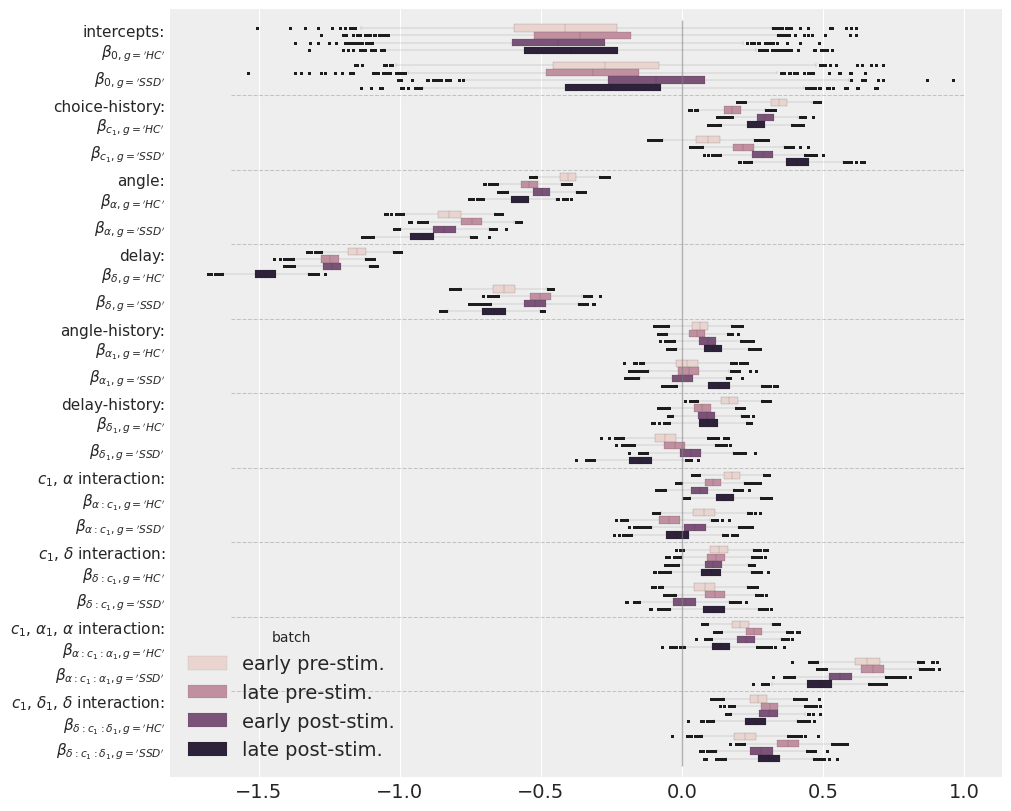

In [45]:
traces = {
    "1_pre1": trace_properties_c1_interactions_woLFCRPA_pre_1,
    "2_pre2": trace_properties_c1_interactions_woLFCRPA_pre_2,
    "3_post1": trace_properties_c1_interactions_woLFCRPA_post_1,
    "4_post2": trace_properties_c1_interactions_woLFCRPA_post_2
}
summaries = pd.DataFrame()
for name in traces.keys():
    summary = traces[name].posterior.to_dataframe().reset_index(drop=True).drop(columns=["1|subj_sigma", "1|subj"])#.drop_duplicates()
    summary["name"] = name
    summaries = pd.concat([summaries, summary])

# calculate group specific parameters using means and interaction effects
summaries["inter_HC"] = summaries["Intercept"] - summaries["group"]
summaries["inter_SSD"] = summaries["Intercept"] + summaries["group"]

summaries["c1_HC"] = summaries["c1"] - summaries["group:c1"]
summaries["c1_SZ"] = summaries["c1"] + summaries["group:c1"]

summaries["delay_HC"] = summaries["delay_norm"] - summaries["group:delay_norm"]
summaries["delay_SZ"] = summaries["delay_norm"] + summaries["group:delay_norm"]
summaries["angle_HC"] = summaries["angle_norm"] - summaries["group:angle_norm"]
summaries["angle_SZ"] = summaries["angle_norm"] + summaries["group:angle_norm"]
summaries["delay1_HC"] = summaries["delay1_norm"] - summaries["group:delay1_norm"]
summaries["delay1_SZ"] = summaries["delay1_norm"] + summaries["group:delay1_norm"]
summaries["angle1_HC"] = summaries["angle1_norm"] - summaries["group:angle1_norm"]
summaries["angle1_SZ"] = summaries["angle1_norm"] + summaries["group:angle1_norm"]

summaries["a:c1_HC"] = summaries["angle_norm:c1"] - summaries["group:angle_norm:c1"]
summaries["a:c1_SZ"] = summaries["angle_norm:c1"] + summaries["group:angle_norm:c1"]
summaries["d:c1_HC"] = summaries["delay_norm:c1"] - summaries["group:delay_norm:c1"]
summaries["d:c1_SZ"] = summaries["delay_norm:c1"] + summaries["group:delay_norm:c1"]


summaries["a:c1:a1_HC"] = summaries["angle_norm:c1:angle1_norm"] - summaries["group:angle_norm:c1:angle1_norm"]
summaries["a:c1:a1_SSD"] = summaries["angle_norm:c1:angle1_norm"] + summaries["group:angle_norm:c1:angle1_norm"]

summaries["d:c1:d1_HC"] = summaries["delay_norm:c1:delay1_norm"] - summaries["group:delay_norm:c1:delay1_norm"]
summaries["d:c1:d1_SSD"] = summaries["delay_norm:c1:delay1_norm"] + summaries["group:delay_norm:c1:delay1_norm"]

# select columns for plotting
new_cols = ["inter_HC", "inter_SSD",
    
            "c1_HC", "c1_SZ",
            "angle_HC", "angle_SZ", "delay_HC", "delay_SZ",

            # trial-history
            "angle1_HC", "angle1_SZ", "delay1_HC", "delay1_SZ",

            # choice-history property interactions
            "a:c1_HC", "a:c1_SZ",
            "d:c1_HC", "d:c1_SZ",

            # 3 way interactions
            "a:c1:a1_HC", "a:c1:a1_SSD",
            "d:c1:d1_HC", "d:c1:d1_SSD",

            "name"]
summaries = summaries[new_cols]

# rename columns to fit with paper notation
# summaries.columns = ["choice-history, HC\n$\\beta_{c_1, g='HC'}$", "choice-history, SSD\n$\\beta_{c_1, g='SSD'}$",
#                     "angle, HC\n$\\beta_{\\alpha, g='HC'}$", "angle, SSD\n$\\beta_{\\alpha, g='SSD'}$",
#                     "delay, HC\n$\\beta_{\\delta, g='HC'}$", "delay, SSD\n$\\beta_{\\delta, g='SSD'}$",
#                     "angle-history, HC\n$\\beta_{\\alpha_1, g='HC'}$", "angle-history, SSD\n$\\beta_{\\alpha_1, g='SSD'}$",
#                     "delay-history, HC\n$\\beta_{\\delta_1, g='HC'}$", "delay-history, SSD\n$\\beta_{\\delta_1, g='SSD'}$",

#                     "c, $\\alpha_1$, $\\alpha$ interaction, HC\n$\\beta_{\\alpha:c_1:\\alpha_1, g='HC'}$", 
#                     "c, $\\alpha_1$, $\\alpha$ interaction, SSD\n$\\beta_{\\alpha:c_1:\\alpha_1, g='SSD'}$",
#                     # "d:c1:d1_HC", "d:c1:d1_SSD",
#                     "name"]
summaries.columns = ["intercepts:\n$\\beta_{0, g='HC'}$", "$\\beta_{0, g='SSD'}$",

                    "choice-history:\n$\\beta_{c_1, g='HC'}$", "$\\beta_{c_1, g='SSD'}$",
                    "angle:\n$\\beta_{\\alpha, g='HC'}$", "$\\beta_{\\alpha, g='SSD'}$",
                    "delay:\n$\\beta_{\\delta, g='HC'}$", "$\\beta_{\\delta, g='SSD'}$",

                    # trial-history
                    "angle-history:\n$\\beta_{\\alpha_1, g='HC'}$", "$\\beta_{\\alpha_1, g='SSD'}$",
                    "delay-history:\n$\\beta_{\\delta_1, g='HC'}$", "$\\beta_{\\delta_1, g='SSD'}$",

                    # choice-history property interactions
                    "$c_1$, $\\alpha$ interaction:\n$\\beta_{\\alpha:c_1, g='HC'}$", "$\\beta_{\\alpha:c_1, g='SSD'}$",
                    "$c_1$, $\\delta$ interaction:\n$\\beta_{\\delta:c_1, g='HC'}$", "$\\beta_{\\delta:c_1, g='SSD'}$",

                    # 3 way interactions
                    "$c_1$, $\\alpha_1$, $\\alpha$ interaction:\n$\\beta_{\\alpha:c_1:\\alpha_1, g='HC'}$", 
                    "$\\beta_{\\alpha:c_1:\\alpha_1, g='SSD'}$",

                    "$c_1$, $\\delta_1$, $\\delta$ interaction:\n$\\beta_{\\delta:c_1:\\delta_1, g='HC'}$", 
                    "$\\beta_{\\delta:c_1:\\delta_1, g='SSD'}$",

                    "name"]

# reshape/ stack data for plotting
def stack(group):
    name = group["name"].iloc[0]
    group = group.drop(columns=["name"])
    group = group.stack().reset_index()
    group.columns = ["level", "var", "value"]
    group["name"] = name
    return group
sum_long = summaries.groupby("name", group_keys=False).apply(stack)


# define colors
colors = ["red", "blue", "green", "yellow"]
colors = sns.cubehelix_palette(4)

# create figure
fig, axs = plt.subplots(1,1, figsize=(10,8)) # (8,6)

# prepare background
# axs.fill_between([-1.65, 0.6], 1.5, 5.5, color="lightgrey", alpha=0.2)

# plot data
g = sns.boxplot(sum_long, x="value", y="var", orient="h", hue="name", 
                # width=0.5, 
                palette=colors, 
                linewidth=0.1, fliersize=1)

# styling
## set labels in legend
labels = ["early pre-stim.", "late pre-stim.", "early post-stim.", "late post-stim."]
plt.legend(title="batch")
for text_field, label in zip(g.legend_.texts, labels):
    text_field.set_text(label)

plt.ylabel("")
plt.xlabel("")

## add lines
axs.vlines([0], [-0.5], [len(summaries.columns) - 1.5], linestyles="-", alpha=0.6, linewidth=1, color="grey") # 9.5

for i in range(1, 18, 2):
    axs.hlines([.5 + i], [-1.6], [1.0], linestyles="--", linewidth=0.75, alpha=0.4, color="grey") # right limit used to be 0.6
# axs.hlines([1.5], [-1.6], [1.0], linestyles="--", linewidth=0.75, alpha=0.4, color="grey") # right limit used to be 0.6
# axs.hlines([3.5], [-1.6], [1.0], linestyles="--", linewidth=0.75, alpha=0.4, color="grey") # right limit used to be 0.6
# axs.hlines([5.5], [-1.6], [1.0], linestyles="--", linewidth=0.75, alpha=0.4, color="grey") # right limit used to be 0.6
# axs.hlines([7.5], [-1.6], [1.0], linestyles="--", linewidth=0.75, alpha=0.4, color="grey") # right limit used to be 0.6
# axs.hlines([9.5], [-1.6], [1.0], linestyles="--", linewidth=0.75, alpha=0.4, color="grey") # right limit used to be 0.6

## set axes limitations
# axs.set_xlim(-1.65, 0.65)
# axs.set_ylim(9.6, -0.6)

# set y tick font size
plt.yticks(fontsize=11)#, rotation=15)

plt.tight_layout()
plt.savefig("figures/order_effects_extended_noLFCRPA.pdf")

## SSDs report slightly more causality than HCs

In [36]:
def cohens_d(x, y):
    return (np.mean(x) - np.mean(y)) / np.sqrt( (np.var(x) * len(x) + np.var(y) * len(y) ) / (len(x) + len(y)))

In [38]:
pdf = data.replace({"causal": 1, "non_causal": 0})
a = pdf[pdf["group"] == "HC"]["c"]
b = pdf[pdf["group"] == "SZ"]["c"]

print(a.mean())
print(b.mean())
print(cohens_d(b,a))
ttest(a,b)


0.43833858359584643
0.4535731316847197
0.03066622084539342


TtestResult(statistic=-2.964329240764526, pvalue=0.003035206095406828, df=40390.0)